## Imports

In [263]:
import os
import re

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
import nltk

from nltk.corpus import webtext
# from nltk.tokenize import TweetTokenizer
from nltk.tokenize import sent_tokenize

## Global Variables

In [195]:
DEVICE = "cuda:0"
assert torch.cuda.is_available()


PADDING_TOKEN = 'PAD' # voc 0
UNKNOWN_TOKEN = 'UKN' # voc 1

BATCH_SIZE = 16
EMB_SIZE = 128

VAL_SPLIT = 0.2
TEST_SPLIT = 0.1

# for reproducibility
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.manual_seed(0)

## Vocabulary

In [228]:
class Vocabulary():
    def __init__(
        self, 
        text,
        max_sentence_length : int = 32,
        padding_token : str = PADDING_TOKEN,
        unknown_token : str = UNKNOWN_TOKEN
    ):
        self.padding_token = padding_token
        self.unknown_token = unknown_token
        self.sentences = Vocabulary.prepare_sentences(text, max_sentence_length)
        self.build_vocab()
        
    @staticmethod
    def text_cleaning(string):
        string = re.sub('-\n', '', string)
        string = re.sub(r"""[*#@&%£ö'ä$ü¨~^)('+°¢./><$\[\]`]""", '', string)
        string = re.sub('[0-9]', '', string)
        return re.sub('\n', ' ', string)
    
    @staticmethod
    def prepare_sentences(text, max_sentence_length):
        sentences = sent_tokenize(text)
        sentences = [re.sub(r".*: ", '', sent, 1) for sent in sentences]
        sentences = [Vocabulary.text_cleaning(sentence) for sentence in sentences]
        sentences = [[w.lower() for w in nltk.word_tokenize(sentence)] for sentence in sentences]
        return [sent for sent in sentences if len(sent) < max_sentence_length]
    
    def build_vocab(self):
        vocab = {}
        for tokens in self.sentences:
            for token in tokens:
                if token in vocab.keys():
                    vocab[token] += 1
                else:
                    vocab[token] = 1

        self.vocab = {k: v for k, v in sorted(vocab.items(), key=lambda item: -item[1])}

        self.word_to_idx = {k : (i+2) for i,(k,_) in enumerate(vocab.items())}
        self.word_to_idx[self.padding_token] = 0
        self.word_to_idx[self.unknown_token] = 1
        self.idx_to_word = {v : k for k, v in word_to_idx.items()}
        
    def get_vocab_size(self):
        return len(self.vocab)
    
    def pad_and_truncate(self, tokens, max_length):
        diff = max_length - len(tokens)
        if diff < 0:
            return tokens[:max_length]
        else:
            return tokens + [self.word_to_idx[self.padding_token]] * diff

In [229]:
txt = webtext.raw('overheard.txt')
voc = Vocabulary(txt)

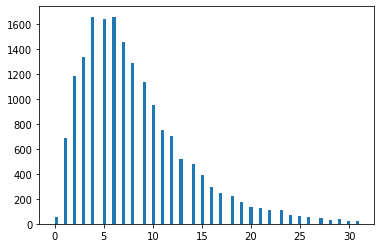

In [230]:
plt.hist([len(sent) for sent in voc.sentences], bins = 100)
plt.show()

In [288]:
class LM_dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        vocabulary : Vocabulary,
        max_length : int
    ):
        self.vocabulary = vocabulary
        self.max_length = max_length
        self.indices = [
            self.vocabulary.pad_and_truncate([self.get_idx(w) for w in sentence], max_length + 1)
            for sentence in vocabulary.sentences if len(sentence) > 1
        ]
        
    def get_idx(self, token):
        try:
            return self.vocabulary.word_to_idx[token]
        except KeyError:
            return self.vocabulary.word_to_idx[self.vocabulary.unknown_token]
        
    def __getitem__(self, idx):
        return {
            'inputs' : torch.LongTensor(self.indices[idx][:self.max_length]).to(DEVICE),
            'labels' : torch.LongTensor(self.indices[idx][1:self.max_length+1]).to(DEVICE)
        }
        
    def __len__(self):
        return len(self.indices)

In [289]:
train_dataset = LM_dataset(
    voc,
    10 
)

In [290]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    pin_memory = False
)

In [291]:
emb_layer = torch.nn.Embedding(
    VOCAB_SIZE,
    EMB_SIZE
).to(DEVICE)

In [292]:
lstm = torch.nn.LSTM(
    input_size = EMB_SIZE,
    hidden_size = 20,
    num_layers = 2,
    batch_first = True
).to(DEVICE)

In [294]:
tensor = emb_layer(train_dataset[1:3]['inputs'])
tensor.shape

torch.Size([2, 11, 128])

In [295]:
h0 = torch.randn(2, 2, 20).to(DEVICE)
c0 = torch.randn(2, 2, 20).to(DEVICE)
output, (hn,cn) = lstm(tensor, (h0, c0))

In [296]:
output.shape

torch.Size([2, 11, 20])

In [297]:
hn.shape

torch.Size([2, 2, 20])

In [298]:
cn.shape

torch.Size([2, 2, 20])

In [328]:
class NextWordPredictorModel(torch.nn.Module):
    def __init__(
        self,
        emb_dim : int,
        vocab_size : int,
        num_lstm_hidden_layers : int,
        hidden_state_size : int,
        dropout : float,
        device : str
    ):
        super().__init__()
        self.num_lstm_hidden_layers = num_lstm_hidden_layers
        self.hidden_state_size = hidden_state_size
        self.device = device
        # Embedding layer
        self.embedding_layer = torch.nn.Embedding(
            vocab_size,
            emb_dim
        ).to(device)
        # LSTM layer (later replace with oupled Input and Forget Gate (CIFG) maybe)
        self.lstm = torch.nn.LSTM(
            input_size = emb_dim,
            hidden_size = hidden_state_size,
            num_layers = num_lstm_hidden_layers,
            dropout = dropout,
            batch_first = True # -> input of the shape (bath size, seq length, emb length)
        ).to(device)
        # FFN for classification on vocab
        self.classifier = torch.nn.Linear(
            hidden_state_size,
            vocab_size
        ).to(device)
        
        self.hidden_state = None
        
        self.optimizer = torch.optim.AdamW(
            self.parameters(),
            lr = 10e-4
        )
        self.criterion = torch.nn.CrossEntropyLoss(
            ignore_index = 0,
            reduction = 'None'
        ).to(device) # may use the weight as prior n_occ / num_words
        
    def forward(self, inputs):
        if self.hidden_state is None:
            # in the case forward is called for testing, init the states at 0
            self.state = self.init_hidden(inputs.shape[0])
        embeddings = self.embedding_layer(inputs)
        output, self.state = self.lstm(embeddings, self.state)
        forward = self.classifier(output)
        return torch.nn.functional.log_softmax(forward, dim = 1)
                
    def init_hidden(self, batch_size):
        return (
            torch.zeros(
                self.num_lstm_hidden_layers, batch_size, self.hidden_state_size
            ).to(self.device),
            torch.zeros(
                self.num_lstm_hidden_layers, batch_size, self.hidden_state_size
            ).to(self.device)
        )

        
    def epoch_step(self, data_loader):
        self.train()
        losses = []
        
        self.init_hidden(data_loader.batch_size)
        
        for batch_idx, batch in enumerate(tqdm(data_loader)):
            for param in self.parameters():
                param.grad = None
            
            target = batch.pop('labels')
            output = self.forward(batch['inputs'])
            loss = self.criterion(output, target)
            
            if self.fp16:
                with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                    scaled_loss.backward()
                self.optimizer.step()
            else:
                loss.backward()
                self.optimizer.step()
    
            losses.append(loss.item())
                
        return losses
    
    def fit(self, num_epochs):
        for epoch in range(1, epochs+1):
            losses = self.epoch_step(train_data_loader, history, epoch)
            train_loss = np.mean(losses)
            print(f"train loss at epoch {epoch} : {train_loss}")

In [329]:
model = NextWordPredictorModel(
    emb_dim  = EMB_SIZE,
    vocab_size = voc.get_vocab_size(),
    num_lstm_hidden_layers = 2,
    hidden_state_size = 32,
    dropout = 0.2,
    device = DEVICE
)

In [330]:
test_tensor = train_dataset[0:3]

In [331]:
model(test_tensor['inputs'])

tensor([[[-2.4440, -2.3661, -2.3807,  ..., -2.4076, -2.3556, -2.4359],
         [-2.4662, -2.3759, -2.4001,  ..., -2.3946, -2.3562, -2.4089],
         [-2.4477, -2.4141, -2.3932,  ..., -2.3781, -2.3804, -2.3922],
         ...,
         [-2.3438, -2.4103, -2.4104,  ..., -2.4173, -2.4361, -2.3847],
         [-2.3513, -2.3971, -2.4090,  ..., -2.4324, -2.4264, -2.3792],
         [-2.3705, -2.4002, -2.4078,  ..., -2.4264, -2.4463, -2.3797]],

        [[-2.3581, -2.3924, -2.3611,  ..., -2.4255, -2.4241, -2.3823],
         [-2.3863, -2.4049, -2.3813,  ..., -2.4033, -2.4183, -2.3682],
         [-2.3997, -2.4219, -2.3798,  ..., -2.4115, -2.4417, -2.3707],
         ...,
         [-2.4104, -2.4096, -2.4170,  ..., -2.3691, -2.3697, -2.4101],
         [-2.3885, -2.3732, -2.4199,  ..., -2.4096, -2.3719, -2.4234],
         [-2.3947, -2.3970, -2.4236,  ..., -2.3910, -2.3531, -2.4272]],

        [[-2.3744, -2.3776, -2.3645,  ..., -2.4510, -2.4231, -2.4171],
         [-2.3957, -2.3905, -2.3842,  ..., -2

In [332]:
model.epoch_step(train_dataloader)

  0%|          | 0/1059 [00:00<?, ?it/s]


ValueError: Expected target size (16, 9662), got torch.Size([16, 10])

In [321]:
train_dataloader.batch_size

16